<a href="https://colab.research.google.com/github/R0N3ldrt/Thesis/blob/main/moded_spectrum_analysis_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spectrum Analysis V2

# Loading Necesary Libraries

In [1]:
# Importing necesary libraries
# Libraries for correct code execution 

import os, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle
import random
import csv
import re
from tqdm import tqdm

from random import random, gauss
from math import modf, pi, cos, sin, sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from plotly.subplots import make_subplots
from scipy.signal import savgol_filter
from scipy.stats.stats import pearsonr
from scipy.stats import spearmanr

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from sklearn.mixture import GaussianMixture

import warnings
warnings.filterwarnings("ignore")

# Load Enviroment

In [2]:
# BLOQUE PARA USAR DESDE COLAB

# Google drive loading as work station for local-usage of the files.
from google.colab import drive
drive.mount('/content/gdrive',force_remount= True)

#-----------------------------------------------------------------------------

Mounted at /content/gdrive


In [3]:
# Lista para cambiar los paths rapido.
workers = ["Ronald", "Local"]

# Change the number to change the paths.
worker = workers[0]

if worker == "Ronald":
  path = "/content/gdrive/MyDrive/Thesis_Workstation/ANN_dataset"
else: path = os.getcwd()

# Load Datasets

In [4]:
input_path = path + "/Spectrum/16QAM/25spans80km_withoutROADMs/dataSet_Spectrum31MHz_Samples_16QAM_75GHz_LongHaul_input_25x80km.xlsx"

## Pre-Processing

In [5]:
df = pd.read_excel(input_path, sheet_name = "Sheet1", skiprows=1)

In [6]:
# Dropping rows that are empty
drop_rows = [drop_row for drop_row in range(325, df.shape[0])]
df_13_samples = df.drop(drop_rows)

In [7]:
print([row for row in range(1, 14)])
print([row for row in range(0, 25)])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


In [8]:
# Adding missing PBRS_id
snippet = []
val_cnt = 1
idx = 0
for sample in range(1, 14):
  for sample_id in range(0, 25):
    df_13_samples.at[idx, 'PBRS_id'] = val_cnt
    idx +=1
    snippet.append(val_cnt)
  val_cnt += 1
df_13_samples['PBRS_id'] = df_13_samples['PBRS_id'].astype(int)

In [9]:

df_13_samples.iloc[0].fillna(method='bfill', inplace=True)

df_13_samples.iloc[1:df_13_samples.shape[0]].fillna(method='pad', inplace=True)

In [10]:
display(df_13_samples)

,row,PBRS_id,Channels,Distance_km,power_dBm,#span,-40,-39.96875,-39.9375,-39.90625,...,39.7187499999999,39.7499999999999,39.7812499999999,39.8124999999999,39.8437499999999,39.8749999999999,39.9062499999999,39.9374999999999,39.9687499999999,39.9999999999999
0,1,1,1,80.0,0,1,-334.501270,-333.132364,-325.572794,-336.320168,...,-335.056696,-328.066995,-325.754530,-328.066995,-328.066995,-325.395278,-321.992445,-328.886037,-322.977492,-335.056696
1,2,1,1,160.0,0,2,-338.049215,-327.846616,-327.474368,-338.873124,...,NaN,-321.746918,-326.565933,-322.586533,-341.617433,-322.586533,NaN,-331.617433,-328.607133,-328.144133
2,3,1,1,240.0,0,3,-335.915875,-332.459387,-349.826960,-328.583144,...,-326.872508,-333.434423,-329.882808,-329.882808,-331.686340,-325.665740,-335.903408,-326.872508,-329.882808,-328.913708
3,4,1,1,320.0,0,4,-330.110140,-337.262521,-332.736237,-339.124990,...,-336.294415,-330.273815,-329.274286,-329.304715,-321.242915,-320.731390,-328.335615,-325.154982,-326.294415,-330.273815
4,5,1,1,400.0,0,5,-336.413189,-330.762275,-332.048845,-337.871202,...,-331.093800,-336.602875,-329.274286,-329.155600,-324.104100,-320.731390,-333.027762,-325.154982,-343.135000,-337.114400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,321,13,1,1680.0,0,21,-54.561583,-44.613902,-41.167754,-40.733658,...,-46.796297,-44.789001,-49.459724,-43.774488,-46.750014,-45.695103,-43.781436,-40.756417,-49.368974,-35.147507
321,322,13,1,1760.0,0,22,-58.293111,-50.937024,-40.632352,-55.283881,...,-54.613867,-42.210508,-41.569807,-46.446182,-52.601701,-45.139597,-46.657479,-50.439532,-45.279847,-47.112150
322,323,13,1,1840.0,0,23,-56.360107,-49.076076,-38.904166,-42.718141,...,-44.865531,-40.877947,-38.035555,-43.307802,-44.275443,-39.932980,-42.285547,-55.159451,-42.410064,-47.629492
323,324,13,1,1920.0,0,24,-48.972740,-44.050182,-48.665758,-48.660555,...,-40.742621,-58.084123,-43.044080,-43.606192,-43.880028,-49.691087,-46.022193,-47.717701,-39.202819,-51.550857


# Cut Tails with on wanted data

## Calculate the average value of groups

In [93]:
def prime_number_finder(stop_gap, total_num_of_data):
  prime_nums = []
  i=2
  while i <= stop_gap:
    if (total_num_of_data % i==0):
      prime_nums.append(i)
      break
    i+=1
  return prime_nums

def aggreagator_v2(df, stop_gap=50):
  total_num_of_data = df.shape[1]
  arr_prime = prime_number_finder(stop_gap, total_num_of_data)
  #agg_num = np.max(arr_prime)
  agg_num = arr_prime[0]

  # Creating new df of aggregate values
  agg_df = pd.DataFrame()

  mid_point = df.shape[1]/2

  agg=0
  loop_cnt=0
  init_column_cnt = 5
  while agg<=total_num_of_data:
    loop_cnt+=1
    # Obtain current last columns stop
    agg=agg_num+init_column_cnt
    # Select working columns
    new_df = df[df.columns[init_column_cnt:agg]]

    init_column_cnt += (agg_num)

    headers = list(new_df.columns.values) 
    if loop_cnt <= mid_point:
      # Get average of freq values for new header
      new_header_name  = headers[-1]
    else:
      new_header_name = headers[0]
    
    # Add aggragated values to new df
    agg_df[new_header_name] = new_df.mean(axis = 1)
  return agg_df

## Select the first sample for testing of the mean values

## Remove tails selectors (return the headers fromt where the data should be selected

In [112]:
def remove_tail(df, cut_val, sample_id):
  columns_selected = []
  old_val = 0
  delta = 0
  mid_point = int(df.shape[1]/2)
  cols_headers  = list(df.columns.values)

  for i in range(0, df.shape[1]):
    if i == 0:
      cell_val = df.iloc[[0], i]
      old_val = cell_val[sample_id]
    else:
      cell_val = df.iloc[[0], i]
      val = cell_val[sample_id]
      delta = abs(old_val-val)
      old_val = val
      if delta > cut_val:
        if i <= mid_point:
          col_name_selected = cols_headers[i+2]
        else:
          col_name_selected = cols_headers[i-2]
          col_name_selected = round(float(col_name_selected), 5)
        columns_selected.append(col_name_selected)

  return columns_selected

In [107]:
# Removing tails conducting multiples loops with variable cutoff value until we get only two columns
def remove_tail_main(df, cut_val, sample_id):
  old_drop_cols = []
  drop_cols = remove_tail(df, cut_val, sample_id)
  while len(drop_cols) != 2:  
    # If len of columns to be dropped are 0 the select the 2 values smaller and bigger of the previous iteration
    if len(drop_cols) == 0 or len(drop_cols) == 1:
      drop_cols = [np.min(old_drop_cols), np.max(old_drop_cols)]
      break
    else:
      old_drop_cols = drop_cols
      drop_cols = remove_tail(df, cut_val, sample_id)
      cut_val += 2
  return drop_cols

In [95]:
def get_working_data_idx(df_mean_sample, sample_id, cut_val = 0):

  df = df_mean_sample.iloc[[sample_id - 1]]

  smoothed_2dg = savgol_filter(df, window_length = 5, polyorder = 2)
  smoothed_df = pd.DataFrame(smoothed_2dg)

  # Adding back headers to the smoothed data
  rename_col = {}
  cnt = 0
  for col in df.columns:
    h_col = round(float(col), 5)
    rename_col[cnt] = str(h_col)
    cnt += 1

  smoothed_df.rename(columns=rename_col, inplace=True)

  agg_df = aggreagator_v2(smoothed_df)

  col_vals = remove_tail_main(agg_df, cut_val=cut_val, sample_id= sample_id)

  left_index_no = smoothed_df.columns.get_loc(col_vals[0])
  rigth_index_no = smoothed_df.columns.get_loc(col_vals[1])

  return left_index_no, rigth_index_no

In [32]:
'''
df_mean_sample = df_13_samples.groupby(['PBRS_id']).mean()
df_mean_sample = df_mean_sample.drop(['row', 'Channels', 'Distance_km', 'power_dBm'], axis = 1)
cut_point = {}
print('Calculating the cutoff values:')
for sample in tqdm(df_mean_sample.index):
  left_index_no, rigth_index_no = get_working_data_idx(df_mean_sample, sample_id = sample)
  cut_point[sample] = (left_index_no, rigth_index_no)
'''

"\ndf_mean_sample = df_13_samples.groupby(['PBRS_id']).mean()\ndf_mean_sample = df_mean_sample.drop(['row', 'Channels', 'Distance_km', 'power_dBm'], axis = 1)\ncut_point = {}\nprint('Calculating the cutoff values:')\nfor sample in tqdm(df_mean_sample.index):\n  left_index_no, rigth_index_no = get_working_data_idx(df_mean_sample, sample_id = sample)\n  cut_point[sample] = (left_index_no, rigth_index_no)\n"

In [108]:
def get_working_data_idx_v2(df_mean_sample, sample_id, cut_val = 0):

  df = df_mean_sample.iloc[[sample_id - 1]]

  agg_df = aggreagator_v2(df)

  col_vals = remove_tail_main(agg_df, cut_val=cut_val, sample_id=sample_id)

  left_index_no = df.columns.get_loc(col_vals[0])
  rigth_index_no = df.columns.get_loc(col_vals[1])

  return left_index_no, rigth_index_no

In [113]:
df_mean_sample = df_13_samples.groupby(['PBRS_id']).mean()
df_mean_sample = df_mean_sample.drop(['row', 'Channels', 'Distance_km', 'power_dBm'], axis = 1)

cut_point = {}
print('Calculating the cutoff values:')
for sample in tqdm(df_mean_sample.index):
  left_index_no, rigth_index_no = get_working_data_idx_v2(df_mean_sample, sample_id = sample)
  cut_point[sample] = (left_index_no, rigth_index_no)

Calculating the cutoff values:


100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


In [114]:
print(cut_point)

{1: (238, 2357), 2: (238, 2344), 3: (251, 2331), 4: (251, 2318), 5: (238, 2357), 6: (238, 2344), 7: (251, 2331), 8: (251, 2331), 9: (238, 2357), 10: (238, 2357), 11: (238, 2344), 12: (251, 2331), 13: (251, 2318)}


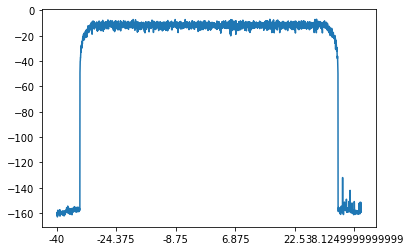

In [17]:
test_df = df_mean_sample.iloc[[0]]
sample_1 = test_df.iloc[0].squeeze()
sample_1.plot()
plt.show()

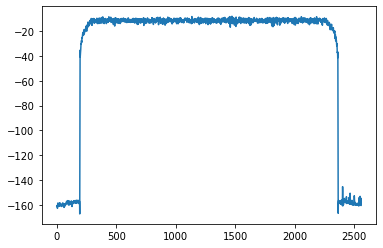

In [18]:
smoothed_2dg = savgol_filter(test_df, window_length = 5, polyorder = 2)
gfg = pd.Series(smoothed_2dg[0])
gfg.plot()
plt.show()

# Pearson Correlation

## Main

In [19]:
# Pearson correlation
#-1 indicates a perfectly negative linear correlation between two variables
#0 indicates no linear correlation between two variables
#1 indicates a perfectly positive linear correlation between two variables

def pearson_correlation(df_13_samples):
  cor_results = {}

  distances = []
  c = 1
  for x in range(0,25):
    t = (x, c*80)
    distances.append(t)
    c += 1
  print('Calculating Correlation Parameters for data samples:')

  for idx, source in tqdm(distances): # source distances loop
    samples_pearson_cor_dict = {}
    
    cnt_first_row = 0
    counter = 1
    for sample_id in df_13_samples['PBRS_id'].unique(): #Samples loop

      sample_df = df_13_samples[df_13_samples['PBRS_id'] == sample_id]
      first_cols_df = sample_df.iloc[:, 0:6]
      working_df = sample_df.iloc[:, cut_point[sample_id][0]+6:cut_point[sample_id][1]+6]
      merge_df = pd.merge(first_cols_df, working_df, left_index=True, right_index=True)

      #var1 = merge_df.iloc[idx, 7:merge_df.shape[1]]
      source_df = merge_df[merge_df['Distance_km'] == source]

      var1 = source_df.iloc[0, 7:source_df.shape[1]]
      #display(merge_df)
      series1 = var1.to_frame()

      vals_1 = series1[cnt_first_row*25+idx].tolist()
      cnt_first_row += 1

      distance_cnt = 1
      pearson_cor_dict = {}

      for index, row in merge_df.iterrows(): # sample row loop
        if distance_cnt*80 != source:
          rslt_df = merge_df[merge_df['row'] == counter]
          var2 = rslt_df.iloc[0, 7:merge_df.shape[1]]
          series2 = var2.to_frame()
          vals_2 = series2[index].tolist()

          cor, p_val = pearsonr(vals_1, vals_2)
          pearson_cor_dict[80*distance_cnt] = (round(cor, 5), round(p_val, 5))

        distance_cnt += 1
        counter += 1
      samples_pearson_cor_dict['sample_id_'+str(sample_id)] = pearson_cor_dict

    cor_results['source_'+str(source)] = samples_pearson_cor_dict
  return cor_results

In [20]:
cor_results = pearson_correlation(df_13_samples)

Calculating Correlation Parameters for data samples:


100%|██████████| 25/25 [00:21<00:00,  1.14it/s]


In [21]:
cor_results['source_80']['sample_id_1']

{160: (0.04641, 0.0327),
 240: (0.05005, 0.02125),
 320: (0.10102, 0.0),
 400: (0.06805, 0.00173),
 480: (0.07649, 0.00043),
 560: (0.09755, 1e-05),
 640: (0.06842, 0.00163),
 720: (0.08425, 0.0001),
 800: (0.01773, 0.41466),
 880: (0.9933, 0.0),
 960: (0.05995, 0.00579),
 1040: (0.06581, 0.00244),
 1120: (0.11438, 0.0),
 1200: (0.08333, 0.00012),
 1280: (0.08956, 4e-05),
 1360: (0.10946, 0.0),
 1440: (0.08466, 0.0001),
 1520: (0.09583, 1e-05),
 1600: (0.03269, 0.13255),
 1680: (0.98282, 0.0),
 1760: (0.07272, 0.00081),
 1840: (0.07916, 0.00027),
 1920: (0.12853, 0.0),
 2000: (0.10358, 0.0)}

## Create dataframe of correlations

In [22]:
def correlation_dict_to_df(cor_results, source_distance):
  source_col = []
  sample_col =[]
  target_header = []
  data_c = []
  data_p = []

  h_cnt = 1
  samples = cor_results['source_'+str(source_distance)]
  for sample_id, target in samples.items():
    cor_data = []
    p_value_data = []
    for target, cor in target.items():
      source_col.append(source_distance)
      sample_col.append(sample_id)
      if h_cnt == 1:
        target_header.append(target)
      cor_data.append(cor[0])
      p_value_data.append(cor[1])
    data_c.append(cor_data)
    data_p.append(p_value_data)
    h_cnt += 1

  cor_df = pd.DataFrame(data_c, columns=target_header)
  cor_df.insert(0, 'source', [str(source_distance) for sample_col in range(1,14)])
  cor_df.insert(1, 'sample_id', [str(sample_col) for sample_col in range(1,14)])

  p_df = pd.DataFrame(data_p, columns=target_header)
  p_df.insert(0, 'source', [str(source_distance) for sample_col in range(1,14)])
  p_df.insert(1, 'sample_id', [str(sample_col) for sample_col in range(1,14)])

  cor_output_path = path + '/Spectrum/correlations/Correlation_Pearson_'+str(source_distance)+'.csv'
  p_output_path = path + '/Spectrum/correlations/Correlation_Pearson_P_Value_'+str(source_distance)+'.csv'

  cor_df.to_csv(cor_output_path, index=False)  
  p_df.to_csv(p_output_path, index=False)  

In [23]:
'''
print('Saving files of correlations calculations')
c = 1
for x in tqdm(range(1,26)):
  distance = c*80
  correlation_dict_to_df(cor_results, source_distance=distance)
  c += 1
'''

"\nprint('Saving files of correlations calculations')\nc = 1\nfor x in tqdm(range(1,26)):\n  distance = c*80\n  correlation_dict_to_df(cor_results, source_distance=distance)\n  c += 1\n"

In [24]:
def correlation_dict_to_df_v2(cor_results, source_distance):
  source_col = []
  sample_col =[]
  target_header = []
  data_c = []
  data_p = []

  h_cnt = 1
  samples = cor_results['source_'+str(source_distance)]
  for sample_id, target in samples.items():
    cor_data = []
    p_value_data = []
    for target, cor in target.items():
      source_col.append(source_distance)
      sample_col.append(sample_id)
      if h_cnt == 1:
        target_header.append(target)
      cor_data.append(cor[0])
      p_value_data.append(cor[1])
    data_c.append(cor_data)
    data_p.append(p_value_data)
    h_cnt += 1
  
  distances = {80: 0, 160: 1, 240: 2, 320: 3, 400: 4, 480: 5, 560: 6, 640: 7, 720: 8, 800: 9, 880: 10, 
               960: 11, 1040: 12, 1120: 13, 1200: 14, 1280: 15, 1360: 16, 1440: 17, 1520: 18, 1600: 19, 1680: 20, 
               1760: 21, 1840: 22, 1920: 23, 2000: 24}

  cor_df = pd.DataFrame(data_c, columns=target_header)
  cor_df.insert(distances[source_distance], source_distance, ['-' for sample_col in range(1,14)]) # Insert null colun
  cor_df.insert(0, 'source', [str(source_distance) for sample_col in range(1,14)])
  cor_df.insert(1, 'sample_id', [str(sample_col) for sample_col in range(1,14)])

  p_df = pd.DataFrame(data_p, columns=target_header)
  p_df.insert(distances[source_distance], source_distance, ['-' for sample_col in range(1,14)]) # Insert null colun
  p_df.insert(0, 'source', [str(source_distance) for sample_col in range(1,14)])
  p_df.insert(1, 'sample_id', [str(sample_col) for sample_col in range(1,14)])

  return cor_df, p_df

In [25]:
'''
print('Saving files of Global correlations calculations')
cor_df_1, p_df_1 = correlation_dict_to_df_v2(cor_results, source_distance=80)
c = 1
for x in tqdm(range(1,26)):
  distance = c*80
  cor_df_x, p_df_x = correlation_dict_to_df_v2(cor_results, source_distance=distance)
  cor_df_1 = pd.concat([cor_df_1,cor_df_x],join='inner')

  p_df_1 = pd.concat([p_df_1,p_df_x],join='inner')
  c += 1

cor_output_path = path + '/Spectrum/correlations/Global_Correlation_Pearson.csv'
cor_df_1.to_csv(cor_output_path, index=False)

p_output_path = path + '/Spectrum/correlations/Gloabl_Correlation_Pearson_P_Value.csv'
p_df_1.to_csv(p_output_path, index=False)  
'''

"\nprint('Saving files of Global correlations calculations')\ncor_df_1, p_df_1 = correlation_dict_to_df_v2(cor_results, source_distance=80)\nc = 1\nfor x in tqdm(range(1,26)):\n  distance = c*80\n  cor_df_x, p_df_x = correlation_dict_to_df_v2(cor_results, source_distance=distance)\n  cor_df_1 = pd.concat([cor_df_1,cor_df_x],join='inner')\n\n  p_df_1 = pd.concat([p_df_1,p_df_x],join='inner')\n  c += 1\n\ncor_output_path = path + '/Spectrum/correlations/Global_Correlation_Pearson.csv'\ncor_df_1.to_csv(cor_output_path, index=False)\n\np_output_path = path + '/Spectrum/correlations/Gloabl_Correlation_Pearson_P_Value.csv'\np_df_1.to_csv(p_output_path, index=False)  \n"

## Pickle out the dictionary of correlations

In [26]:
def pickle_out(dump_file, filename):
  filepath = path+"/pickle_folder/"+str(filename)+".pickle"
  pickleout = open(filepath, "wb")
  pickle.dump(dump_file, pickleout)
  pickleout.close()

In [27]:
#pickle_out(cor_results, 'correlation_spectrum')

## Test plots

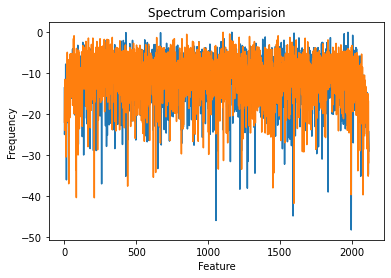

Blue is d1 and Orange is d2


In [28]:
# Scatter plot with day against tip
sample_id = 1 # Test sample 1

sample_df = df_13_samples[df_13_samples['PBRS_id'] == sample_id]
first_cols_df = sample_df.iloc[:, 0:6]
working_df = sample_df.iloc[:, cut_point[sample_id][0]+6:cut_point[sample_id][1]+6]
merge_df = pd.merge(first_cols_df, working_df, left_index=True, right_index=True)

d1 = merge_df.loc[(merge_df['Distance_km'] == 80) & (merge_df['PBRS_id'] == sample_id)]
d2 = merge_df.loc[(merge_df['Distance_km'] == 800) & (merge_df['PBRS_id'] == sample_id)]

d1 = d1.iloc[:, 6:d1.shape[1]]
d2 = d2.iloc[:, 6:d2.shape[1]]

d1 = d1.iloc[0].to_numpy()
d2 = d2.iloc[0].to_numpy()

plt.plot(d1)
plt.plot(d2)
  
# Adding Title to the Plot
plt.title("Spectrum Comparision")
  
# Setting the X and Y labels
plt.xlabel('Feature')
plt.ylabel('Frequency')

plt.show()

print('Blue is d1 and Orange is d2')